<a href="https://colab.research.google.com/github/dominikwernerwolf/coursera/blob/main/Validation_regularisation_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.2


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [3]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
# Save the input and target variables

print(diabetes_dataset.keys())
data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [5]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0))/targets.std()

In [6]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_target.shape)
print(test_target.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [37]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model(train_data):
    model = Sequential([
      Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(1)
    ])
    return model

model = get_model(train_data)

In [38]:
# Print the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 128)               1408      
                                                                 
 dense_66 (Dense)            (None, 128)               16512     
                                                                 
 dense_67 (Dense)            (None, 128)               16512     
                                                                 
 dense_68 (Dense)            (None, 128)               16512     
                                                                 
 dense_69 (Dense)            (None, 128)               16512     
                                                                 
 dense_70 (Dense)            (None, 128)               16512     
                                                                 
 dense_71 (Dense)            (None, 1)                

In [39]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [43]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_target, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [45]:
# Evaluate the model on the test set

model.evaluate(test_data, test_target, verbose=2)

2/2 - 0s - loss: 1.2738 - mae: 0.8808 - 20ms/epoch - 10ms/step


[1.2738325595855713, 0.880786120891571]

#### Plot the learning curves

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

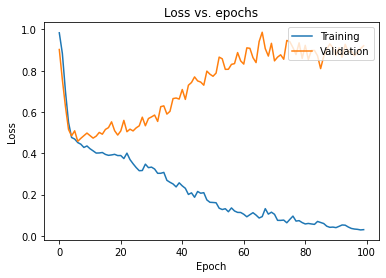

In [47]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [ ]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])
    return model

In [ ]:
# Re-build the model with weight decay and dropout layers



In [ ]:
# Compile the model



In [ ]:
# Train the model, with some of the data reserved for validation



In [ ]:
# Evaluate the model on the test set



#### Plot the learning curves

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [ ]:
# Write a custom callback



In [ ]:
# Re-build the model



In [ ]:
# Compile the model



#### Train the model with the callback

In [ ]:
# Train the model, with some of the data reserved for validation



In [ ]:
# Evaluate the model



In [ ]:
# Make predictions with the model



***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [ ]:
# Re-train the unregularised model



In [ ]:
# Evaluate the model on the test set



In [ ]:
# Re-train the regularised model



In [ ]:
# Evaluate the model on the test set



#### Plot the learning curves

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()